Mounted at /content/drive
Device: cpu
[Masks] Existing: 29, Created: 0
Found 29 (image, mask) pairs
Train: 23 | Val: 6


/tmp/ipython-input-1704069273.py:296: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = torch.cuda.amp.GradScaler(enabled=use_amp)


[01/10] train_loss=0.5827 dice=0.3983 | val_loss=0.6311 dice=0.0000 (best=0.0000)
[02/10] train_loss=0.2704 dice=0.7720 | val_loss=0.8613 dice=0.0000 (best=0.0000)
[03/10] train_loss=0.2124 dice=0.8126 | val_loss=0.9178 dice=0.0000 (best=0.0000)
[04/10] train_loss=0.1558 dice=0.8596 | val_loss=0.8075 dice=0.0867 (best=0.0867)
[05/10] train_loss=0.1674 dice=0.8550 | val_loss=0.5859 dice=0.3351 (best=0.3351)
[06/10] train_loss=0.1395 dice=0.8790 | val_loss=0.3774 dice=0.5975 (best=0.5975)
[07/10] train_loss=0.1193 dice=0.9007 | val_loss=0.3007 dice=0.7114 (best=0.7114)
[08/10] train_loss=0.1127 dice=0.9002 | val_loss=0.2626 dice=0.7641 (best=0.7641)
[09/10] train_loss=0.1211 dice=0.8925 | val_loss=0.1986 dice=0.8533 (best=0.8533)
[10/10] train_loss=0.1078 dice=0.9051 | val_loss=0.1767 dice=0.8801 (best=0.8801)

== Segmentation Metrics (macro, thr=0.50) ==
Split   |  Dice    IoU     Spec     Sens
--------+--------------------------------
Train   |  84.08  73.54   97.25   82.14
Val     |  

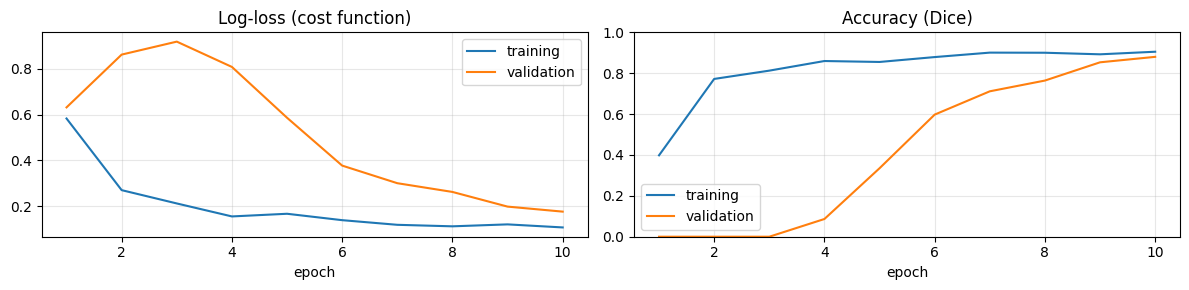

In [ ]:
# ===========================
# Hybrid DeepLabV3+ × TransUNet segmentation
# - Auto-build GT masks from red overlay
# - Train & log metrics (Dice, IoU, Specificity, Sensitivity)
# - Plot curves like the sample figure
# ===========================
import os, cv2, glob, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.flush_and_unmount()         # unmount if already mounted
!rm -rf /content/drive            # clear old directory handle
drive.mount('/content/drive', force_remount=True)
# ---------------------------
# Paths & training config
# ---------------------------
# ===========================
# Hybrid DeepLabV3+ × TransUNet segmentation
# - Auto-build GT masks from red overlay
# - Train & log metrics (Dice, IoU, Specificity, Sensitivity)
# - Plot curves like the sample figure
# ===========================
import os, cv2, glob, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Paths & training config
# ---------------------------
IMAGE_DIR = "/content/drive/MyDrive/dataset/images"
MASK_DIR  = "/content/drive/MyDrive/dataset/masks"    # masks will be written here
SAVE_DIR  = "/content/drive/MyDrive/dataset/models"
os.makedirs(MASK_DIR, exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

IMG_SIZE   = 256
BATCH_SIZE = 8
EPOCHS     = 10
LR         = 2e-4
SEED       = 42
VAL_SPLIT  = 0.2
THR_BIN    = 0.50

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# ---------------------------
# 1) Build GT mask from red overlay (robust, fast)
# ---------------------------
def load_bgr_png_or_jpg(path):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if im is None:
        raise ValueError(f"Cannot read: {path}")
    if im.ndim == 2:
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    if im.ndim == 3 and im.shape[2] == 4:
        im = im[:, :, :3]
    return im

def build_red_mask(bgr):
    """Binary mask from red-dominance with morphology+area filter."""
    H, W = bgr.shape[:2]
    b, g, r = cv2.split(bgr)

    # Drop bright whites (glare)
    near_white = (r > 240) & (g > 240) & (b > 240)

    # Redness ratio r / (r+g+b)
    denom = (r.astype(np.float32) + g.astype(np.float32) + b.astype(np.float32) + 1e-6)
    red_ratio = r.astype(np.float32) / denom

    red8 = np.uint8(np.clip(red_ratio * 255, 0, 255))
    thr, _ = cv2.threshold(red8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr_scaled = max(0, min(255, int(thr * 0.95)))  # a bit looser than Otsu
    mask = (red8 >= thr_scaled).astype(np.uint8) * 255
    mask[near_white] = 0

    # Morphology: open (denoise) then close (fill gaps)
    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k_open,  iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close, iterations=2)

    # Fill contours
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask[:] = 0
    cv2.drawContours(mask, cnts, -1, 255, thickness=cv2.FILLED)

    # Remove tiny specks
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    min_area = max(400, int(0.001 * H * W))
    keep = np.zeros(num, dtype=bool)
    for i in range(1, num):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            keep[i] = True
    out = np.zeros_like(mask)
    keep_ids = np.where(keep)[0]
    out[np.isin(labels, keep_ids)] = 255
    return out

def prepare_masks(image_dir, mask_dir):
    pats = ["*.png", "*.jpg", "*.jpeg"]
    imgs = []
    for p in pats:
        imgs.extend(sorted(glob.glob(os.path.join(image_dir, p))))
    if not imgs:
        print(f"[WARN] No images found under {image_dir}")
        return 0, 0

    made, exist = 0, 0
    for ip in imgs:
        base = os.path.splitext(os.path.basename(ip))[0]
        mp   = os.path.join(mask_dir, f"{base}_mask.png")
        if os.path.exists(mp):
            exist += 1
            continue
        bgr = load_bgr_png_or_jpg(ip)
        mask = build_red_mask(bgr)
        cv2.imwrite(mp, mask)
        made += 1
    print(f"[Masks] Existing: {exist}, Created: {made}")
    return exist, made

_ = prepare_masks(IMAGE_DIR, MASK_DIR)

# ---------------------------
# 2) Dataset / DataLoader
# ---------------------------
def list_pairs(image_dir, mask_dir):
    pats = ["*.png", "*.jpg", "*.jpeg"]
    img_paths = []
    for p in pats:
        img_paths.extend(sorted(glob.glob(os.path.join(image_dir, p))))
    pairs = []
    for ip in img_paths:
        base = os.path.splitext(os.path.basename(ip))[0]
        mp = os.path.join(mask_dir, f"{base}_mask.png")
        if os.path.exists(mp):
            pairs.append((ip, mp))
    return pairs

pairs = list_pairs(IMAGE_DIR, MASK_DIR)
print(f"Found {len(pairs)} (image, mask) pairs")

class SegDataset(Dataset):
    def __init__(self, pairs, img_size=256, augment=False):
        self.pairs = pairs
        self.img_size = img_size
        self.augment = augment

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = load_bgr_png_or_jpg(ip)
        msk = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)

        img_r = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)
        msk_r = cv2.resize(msk, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # light flips
        if self.augment and random.random() < 0.5:
            img_r = np.ascontiguousarray(np.flip(img_r, axis=1))
            msk_r = np.ascontiguousarray(np.flip(msk_r, axis=1))
        if self.augment and random.random() < 0.2:
            img_r = np.ascontiguousarray(np.flip(img_r, axis=0))
            msk_r = np.ascontiguousarray(np.flip(msk_r, axis=0))

        img_t = torch.from_numpy(img_r.transpose(2,0,1)).float() / 255.0   # [3,H,W]
        msk_t = torch.from_numpy((msk_r > 127).astype(np.float32)).unsqueeze(0)  # [1,H,W]
        return img_t, msk_t, os.path.basename(ip)

# split
N = len(pairs)
idxs = list(range(N)); random.shuffle(idxs)
cut = int((1.0 - VAL_SPLIT) * N)
train_pairs = [pairs[i] for i in idxs[:cut]]
val_pairs   = [pairs[i] for i in idxs[cut:]]
print(f"Train: {len(train_pairs)} | Val: {len(val_pairs)}")

train_ds = SegDataset(train_pairs, IMG_SIZE, augment=True)
val_ds   = SegDataset(val_pairs,   IMG_SIZE, augment=False)

pin = (DEVICE == "cuda")
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=pin)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin)

# ---------------------------
# 3) Model: DeepLabV3+ × TransUNet
# ---------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.atrous1  = nn.Conv2d(in_ch, out_ch, 1)
        self.atrous6  = nn.Conv2d(in_ch, out_ch, 3, padding=6,  dilation=6)
        self.atrous12 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
        self.atrous18 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
        self.pool     = nn.AdaptiveAvgPool2d(1)
        self.pool_conv= nn.Conv2d(in_ch, out_ch, 1)
        self.fuse     = nn.Conv2d(out_ch*5, out_ch, 1)

    def forward(self, x):
        size = x.shape[2:]
        gp = self.pool(x)
        gp = F.interpolate(self.pool_conv(gp), size=size, mode='bilinear', align_corners=False)
        x1 = self.atrous1(x); x2 = self.atrous6(x); x3 = self.atrous12(x); x4 = self.atrous18(x)
        out = torch.cat([x1,x2,x3,x4,gp], dim=1)
        return self.fuse(out)

class TransformerDecoder(nn.Module):
    def __init__(self, dim, num_heads=8, ff_dim=2048):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=False)
        self.ffn  = nn.Sequential(nn.Linear(dim, ff_dim), nn.ReLU(), nn.Linear(ff_dim, dim))
        self.n1   = nn.LayerNorm(dim)
        self.n2   = nn.LayerNorm(dim)

    def forward(self, x_seq):  # [HW, B, C]
        a, _ = self.attn(x_seq, x_seq, x_seq)
        x = self.n1(x_seq + a)
        f = self.ffn(x)
        return self.n2(x + f)

class DecoderSharpen(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(ch, ch, 3, padding=1), nn.BatchNorm2d(ch), nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1), nn.BatchNorm2d(ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class DeepLabV3Plus_TransUNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.stem = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)  # /2
        self.enc1 = backbone.layer1  # /4
        self.enc2 = backbone.layer2  # /8
        self.enc3 = backbone.layer3  # /16
        self.enc4 = backbone.layer4  # /32 (2048c)

        self.aspp   = ASPP(2048, 256)
        self.trans  = TransformerDecoder(256)
        self.sharp  = DecoderSharpen(256)
        self.skip1x1= nn.Conv2d(256, 256, 1)
        self.head   = nn.Conv2d(256, num_classes, 1)

    def encoder(self, x):
        x = self.stem(x)
        skip = self.enc1(x)
        x = self.enc2(skip)
        x = self.enc3(x)
        x = self.enc4(x)
        x = self.aspp(x)
        return x, skip

    def forward(self, x_in):
        in_h, in_w = x_in.shape[2], x_in.shape[3]
        x, skip = self.encoder(x_in)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2,0,1)           # [HW,B,C]
        x = self.trans(x).permute(1,2,0).contiguous().view(b, c, h, w)
        x = self.sharp(x)
        skip_up = F.interpolate(skip, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = x + self.skip1x1(skip_up)
        x = self.head(x)
        x = F.interpolate(x, size=(in_h, in_w), mode="bilinear", align_corners=False)  # match targets
        return x

model = DeepLabV3Plus_TransUNet(num_classes=1).to(DEVICE)

# ---------------------------
# 4) Loss, optimizer
# ---------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
use_amp  = (DEVICE == "cuda")
scaler   = torch.cuda.amp.GradScaler(enabled=use_amp)

# ---------------------------
# 5) Segmentation metrics (Dice, IoU, Specificity, Sensitivity)
# ---------------------------
def _conf_counts_from_logits(logits, targets, thr=0.5):
    """Return TP, FP, TN, FN (ints) from raw logits vs binary targets."""
    probs = torch.sigmoid(logits)
    preds = (probs > thr).to(torch.bool)
    t     = (targets > 0.5).to(torch.bool)
    tp = (preds & t).sum().item()
    fp = (preds & (~t)).sum().item()
    fn = ((~preds) & t).sum().item()
    tn = ((~preds) & (~t)).sum().item()
    return tp, fp, tn, fn

@torch.no_grad()
def evaluate_segmentation(model, loader, device, thr=0.5, reduce="macro"):
    """
    Returns: dict with dice, iou, specificity, sensitivity (floats in [0,1]).
    reduce: "macro" (mean per-image) or "micro" (over all pixels).
    """
    model.eval()
    eps = 1e-7
    if reduce == "micro":
        TP=FP=TN=FN=0
        for imgs, masks, _ in loader:
            imgs = imgs.to(device, non_blocking=(device=="cuda"))
            masks= masks.to(device, non_blocking=(device=="cuda"))
            logits = model(imgs)
            tp, fp, tn, fn = _conf_counts_from_logits(logits, masks, thr)
            TP += tp; FP += fp; TN += tn; FN += fn
        dice = (2*TP) / (2*TP + FP + FN + eps)
        iou  = TP / (TP + FP + FN + eps)
        spec = TN / (TN + FP + eps)
        sens = TP / (TP + FN + eps)
        return {"dice": dice, "iou": iou, "specificity": spec, "sensitivity": sens}

    # macro
    dices=[]; ious=[]; specs=[]; senss=[]
    for imgs, masks, _ in loader:
        imgs = imgs.to(device, non_blocking=(device=="cuda"))
        masks= masks.to(device, non_blocking=(device=="cuda"))
        logits = model(imgs)
        B = imgs.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > thr).to(torch.bool)
        gt    = (masks > 0.5).to(torch.bool)
        for b in range(B):
            p = preds[b,0]; g = gt[b,0]
            tp = (p & g).sum().item()
            fp = (p & (~g)).sum().item()
            fn = ((~p) & g).sum().item()
            tn = ((~p) & (~g)).sum().item()
            dice = (2*tp) / (2*tp + fp + fn + 1e-7)
            iou  = tp / (tp + fp + fn + 1e-7)
            spec = tn / (tn + fp + 1e-7)
            sens = tp / (tp + fn + 1e-7)
            dices.append(dice); ious.append(iou); specs.append(spec); senss.append(sens)
    return {
        "dice": float(np.mean(dices) if dices else 0.0),
        "iou": float(np.mean(ious) if ious else 0.0),
        "specificity": float(np.mean(specs) if specs else 0.0),
        "sensitivity": float(np.mean(senss) if senss else 0.0),
    }

# ---------------------------
# 6) Train for EPOCHS, track histories for plotting
# ---------------------------
def run_epoch(loader, train=True, thr=THR_BIN):
    model.train(mode=train)
    total_loss = 0.0
    # micro-aggregation over the epoch for Dice
    DNUM = DDEM = 0.0
    n_pix = 0
    for imgs, masks, _ in loader:
        imgs  = imgs.to(DEVICE, non_blocking=(DEVICE=="cuda"))
        masks = masks.to(DEVICE, non_blocking=(DEVICE=="cuda"))

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.autocast(device_type="cuda", enabled=use_amp):
                logits = model(imgs)
                loss = criterion(logits, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, masks)

        total_loss += loss.item() * imgs.size(0)

        # Dice micro terms (from predictions)
        tp, fp, tn, fn = _conf_counts_from_logits(logits.detach(), masks, thr)
        DNUM += 2.0 * tp
        DDEM += 2.0 * tp + fp + fn
        n_pix += imgs.size(0)

    avg_loss = total_loss / max(1, n_pix)
    dice = DNUM / max(DDEM, 1e-7)
    return avg_loss, dice

tr_loss_hist, va_loss_hist = [], []
tr_dice_hist, va_dice_hist = [], []

best_val_dice = -1.0
best_path = os.path.join(SAVE_DIR, "hybrid_best.pt")

for ep in range(1, EPOCHS+1):
    tr_loss, tr_dice = run_epoch(train_dl, train=True, thr=THR_BIN)
    va_loss, va_dice = run_epoch(val_dl,   train=False, thr=THR_BIN)

    tr_loss_hist.append(tr_loss); tr_dice_hist.append(tr_dice)
    va_loss_hist.append(va_loss); va_dice_hist.append(va_dice)

    if va_dice > best_val_dice:
        best_val_dice = va_dice
        torch.save(model.state_dict(), best_path)

    print(f"[{ep:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} dice={tr_dice:.4f} | "
          f"val_loss={va_loss:.4f} dice={va_dice:.4f} (best={best_val_dice:.4f})")

# Load best
model.load_state_dict(torch.load(best_path, map_location=DEVICE))

# ---------------------------
# 7) Final metrics (macro) on Train & Val
# ---------------------------
metrics_train = evaluate_segmentation(model, train_dl, DEVICE, thr=THR_BIN, reduce="macro")
metrics_val   = evaluate_segmentation(model, val_dl,   DEVICE, thr=THR_BIN, reduce="macro")

print("\n== Segmentation Metrics (macro, thr={:.2f}) ==".format(THR_BIN))
print("Split   |  Dice    IoU     Spec     Sens")
print("--------+--------------------------------")
print("Train   | {:6.2f} {:6.2f} {:7.2f} {:7.2f}".format(
    metrics_train["dice"]*100, metrics_train["iou"]*100,
    metrics_train["specificity"]*100, metrics_train["sensitivity"]*100))
print("Val     | {:6.2f} {:6.2f} {:7.2f} {:7.2f}".format(
    metrics_val["dice"]*100, metrics_val["iou"]*100,
    metrics_val["specificity"]*100, metrics_val["sensitivity"]*100))

# ---------------------------
# 8) Plots like the sample figure
# ---------------------------
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(12,3))
# Left: Log-loss (cost function)
ax1 = plt.subplot(1,2,1)
ax1.plot(epochs, tr_loss_hist, label="training")
ax1.plot(epochs, va_loss_hist, label="validation")
ax1.set_title("Log-loss (cost function)")
ax1.set_xlabel("epoch"); ax1.set_ylabel("")
ax1.legend(); ax1.grid(True, alpha=0.3)

# Right: Accuracy (Dice)
ax2 = plt.subplot(1,2,2)
ax2.plot(epochs, tr_dice_hist, label="training")
ax2.plot(epochs, va_dice_hist, label="validation")
ax2.set_title("Accuracy (Dice)")
ax2.set_xlabel("epoch"); ax2.set_ylim(0.0, 1.0)
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


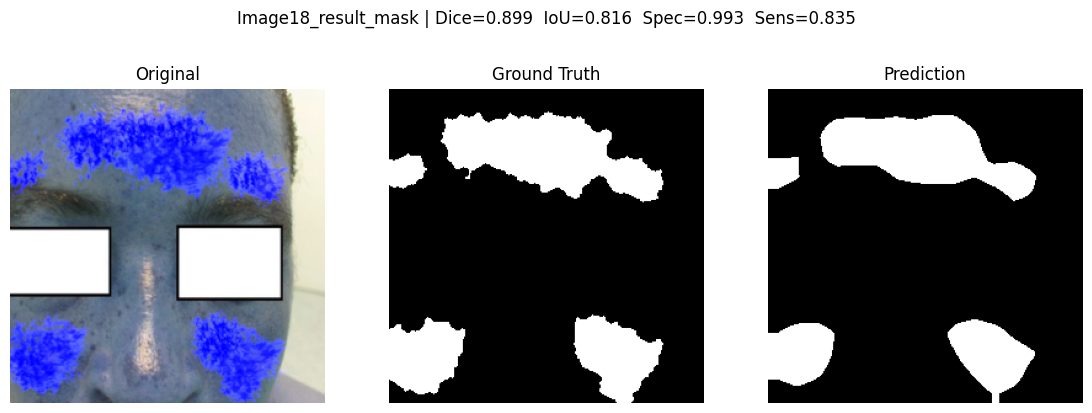

[RESULT] Image18_result_mask  Dice=0.8986  IoU=0.8159  Spec=0.9933  Sens=0.8354  | saved: /content/drive/MyDrive/dataset/models/val_all_triptychs/Image18_result_mask_triptych.png


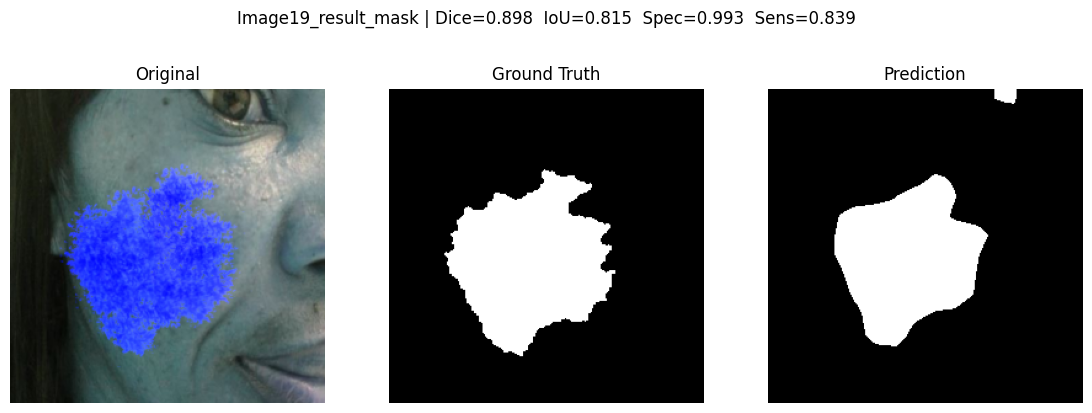

[RESULT] Image19_result_mask  Dice=0.8980  IoU=0.8149  Spec=0.9929  Sens=0.8387  | saved: /content/drive/MyDrive/dataset/models/val_all_triptychs/Image19_result_mask_triptych.png


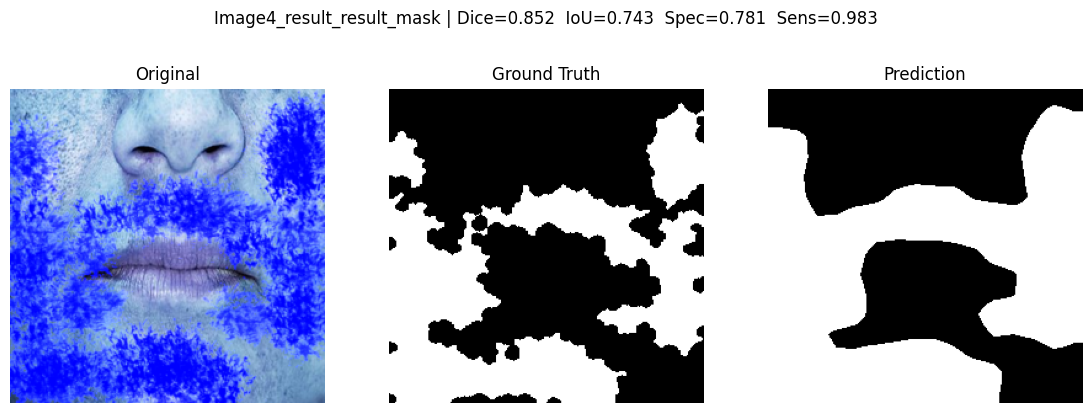

[RESULT] Image4_result_result_mask  Dice=0.8524  IoU=0.7427  Spec=0.7807  Sens=0.9833  | saved: /content/drive/MyDrive/dataset/models/val_all_triptychs/Image4_result_result_mask_triptych.png


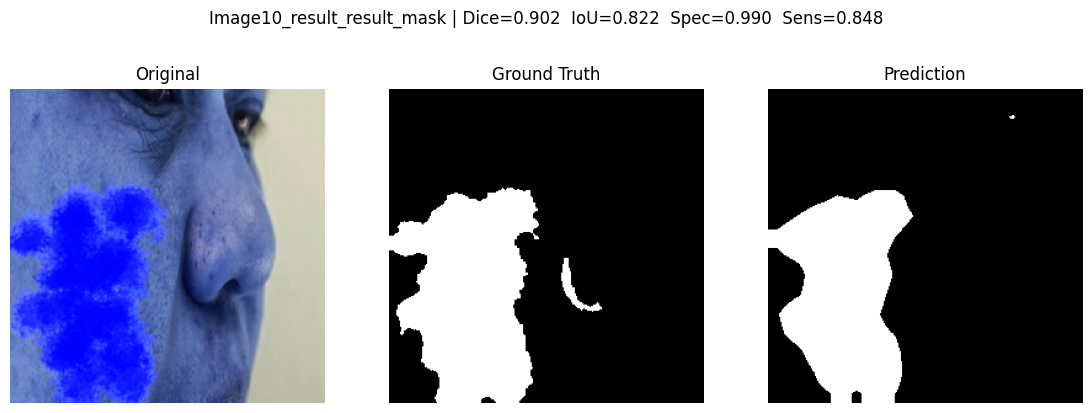

[RESULT] Image10_result_result_mask  Dice=0.9024  IoU=0.8222  Spec=0.9904  Sens=0.8484  | saved: /content/drive/MyDrive/dataset/models/val_all_triptychs/Image10_result_result_mask_triptych.png


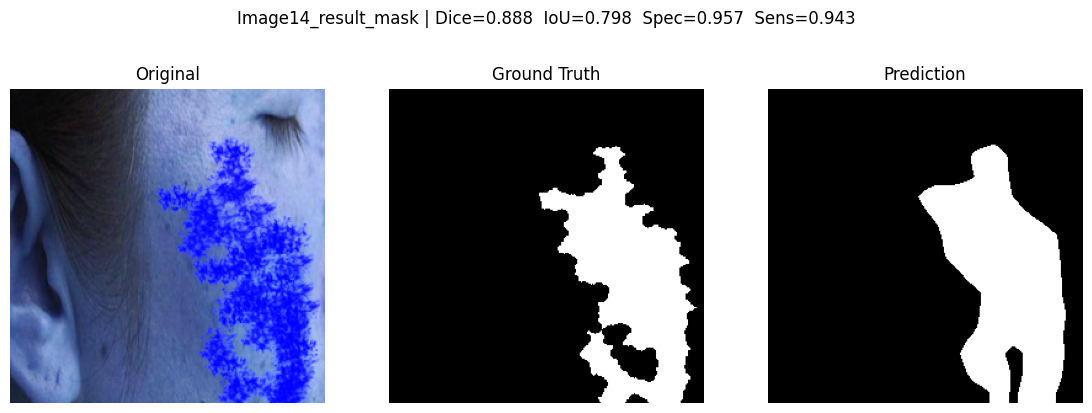

[RESULT] Image14_result_mask  Dice=0.8875  IoU=0.7978  Spec=0.9567  Sens=0.9430  | saved: /content/drive/MyDrive/dataset/models/val_all_triptychs/Image14_result_mask_triptych.png


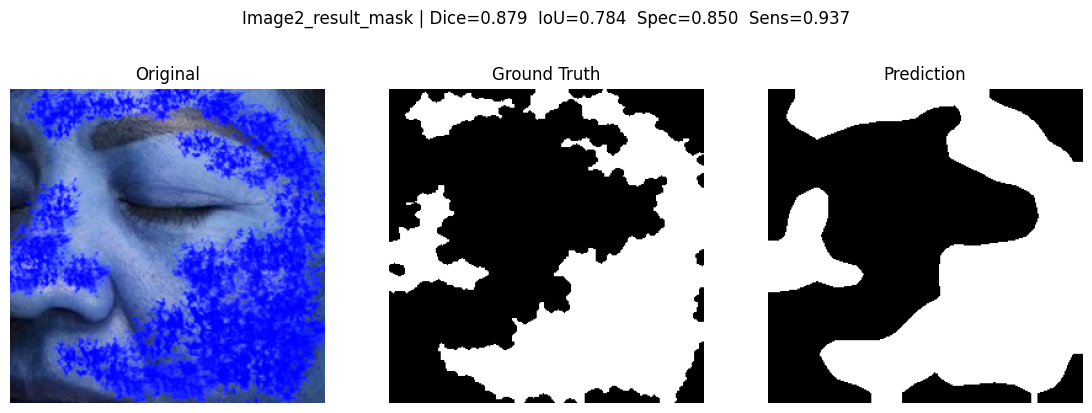

[RESULT] Image2_result_mask  Dice=0.8789  IoU=0.7839  Spec=0.8502  Sens=0.9366  | saved: /content/drive/MyDrive/dataset/models/val_all_triptychs/Image2_result_mask_triptych.png


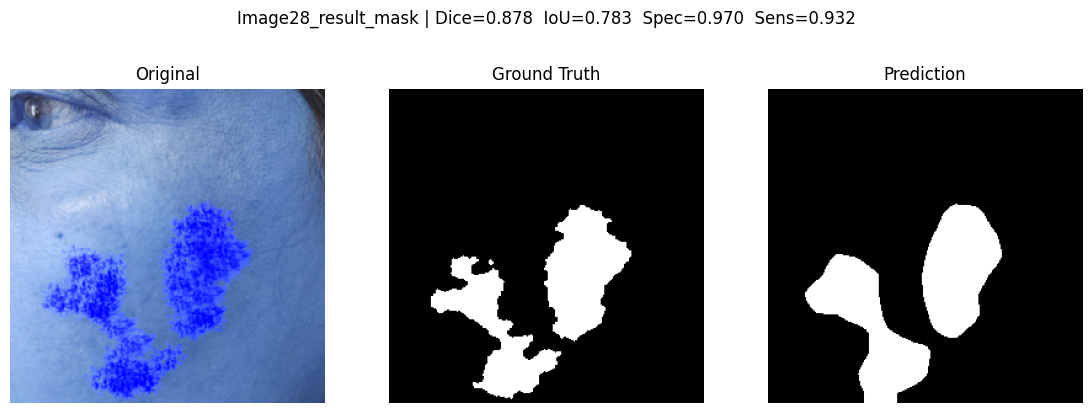

[RESULT] Image28_result_mask  Dice=0.8785  IoU=0.7832  Spec=0.9701  Sens=0.9325  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image28_result_mask_triptych.png


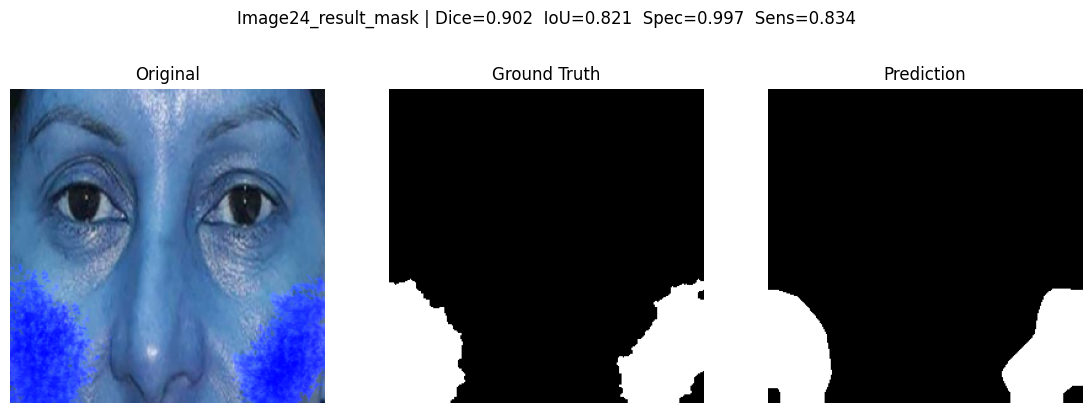

[RESULT] Image24_result_mask  Dice=0.9018  IoU=0.8212  Spec=0.9974  Sens=0.8336  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image24_result_mask_triptych.png


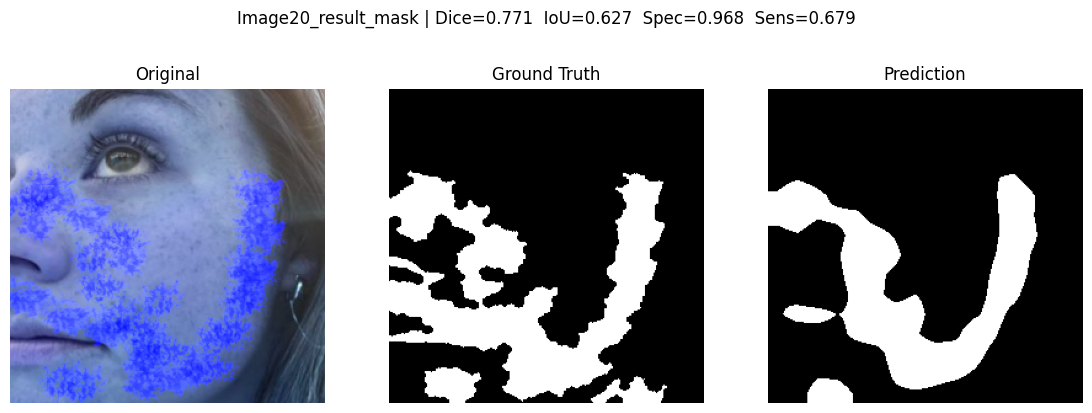

[RESULT] Image20_result_mask  Dice=0.7705  IoU=0.6267  Spec=0.9678  Sens=0.6792  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image20_result_mask_triptych.png


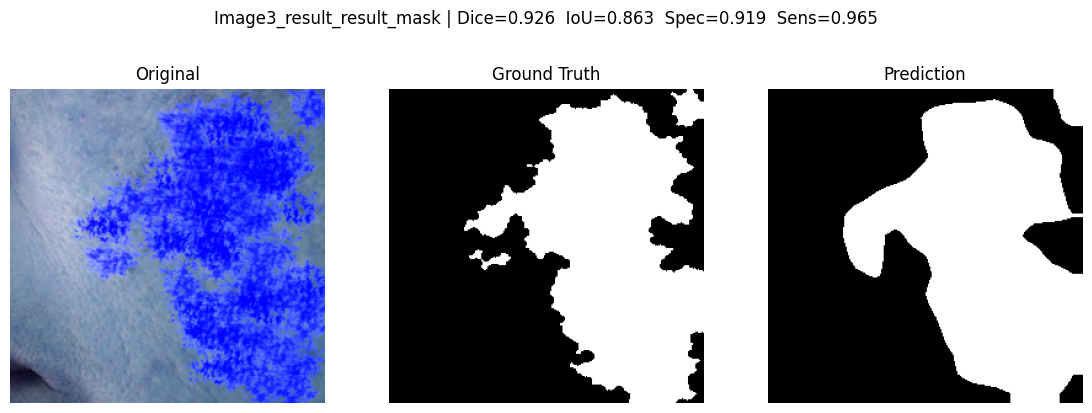

[RESULT] Image3_result_result_mask  Dice=0.9265  IoU=0.8630  Spec=0.9193  Sens=0.9651  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image3_result_result_mask_triptych.png


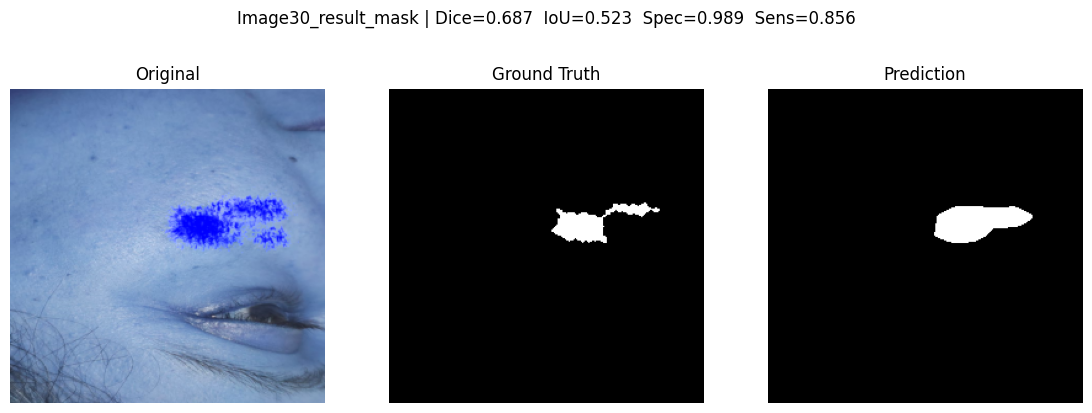

[RESULT] Image30_result_mask  Dice=0.6866  IoU=0.5227  Spec=0.9890  Sens=0.8557  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image30_result_mask_triptych.png


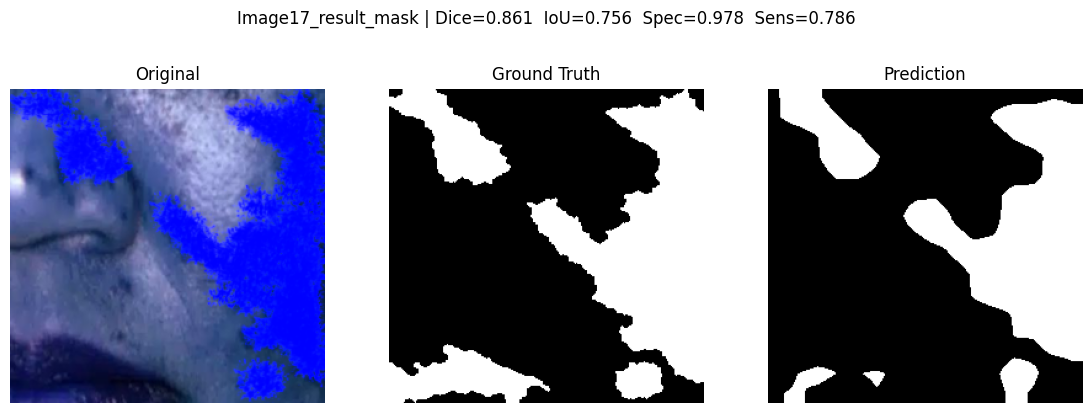

[RESULT] Image17_result_mask  Dice=0.8610  IoU=0.7560  Spec=0.9776  Sens=0.7863  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image17_result_mask_triptych.png


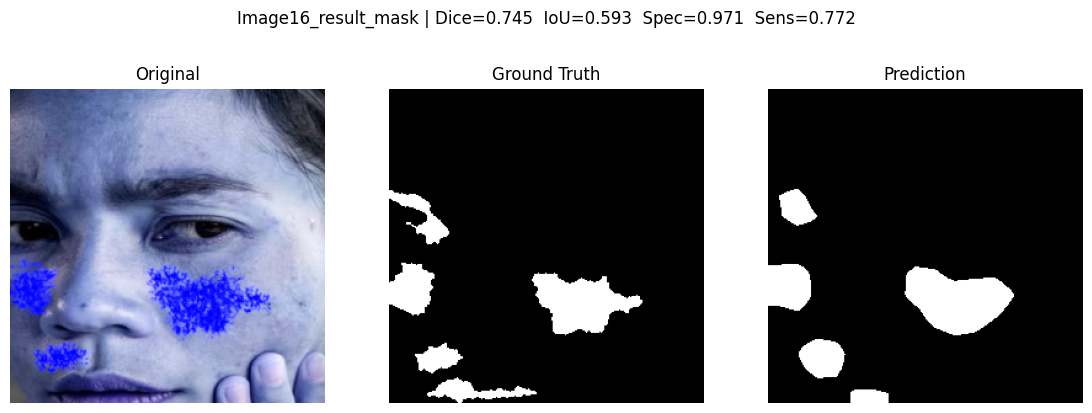

[RESULT] Image16_result_mask  Dice=0.7447  IoU=0.5932  Spec=0.9707  Sens=0.7716  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image16_result_mask_triptych.png


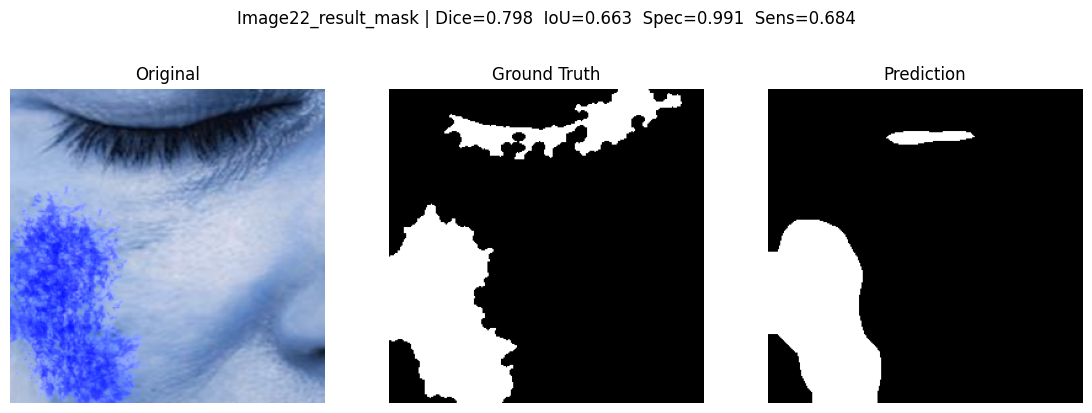

[RESULT] Image22_result_mask  Dice=0.7976  IoU=0.6633  Spec=0.9913  Sens=0.6837  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image22_result_mask_triptych.png


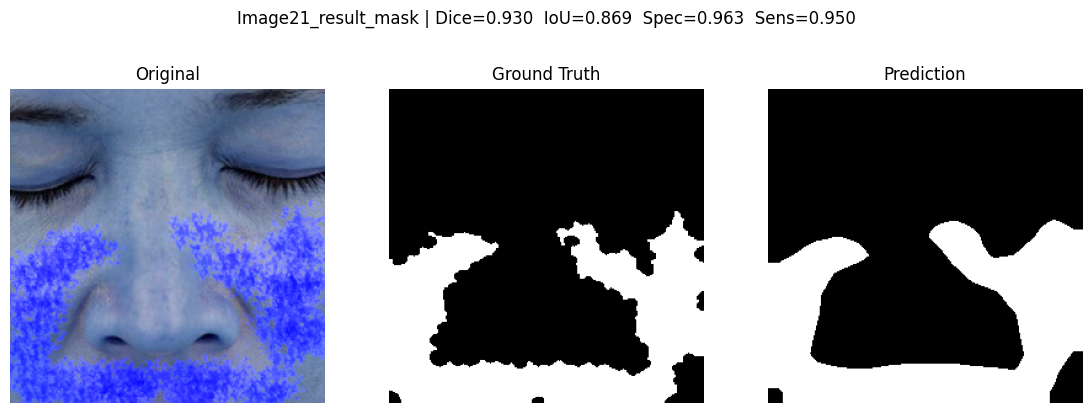

[RESULT] Image21_result_mask  Dice=0.9297  IoU=0.8686  Spec=0.9626  Sens=0.9499  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image21_result_mask_triptych.png


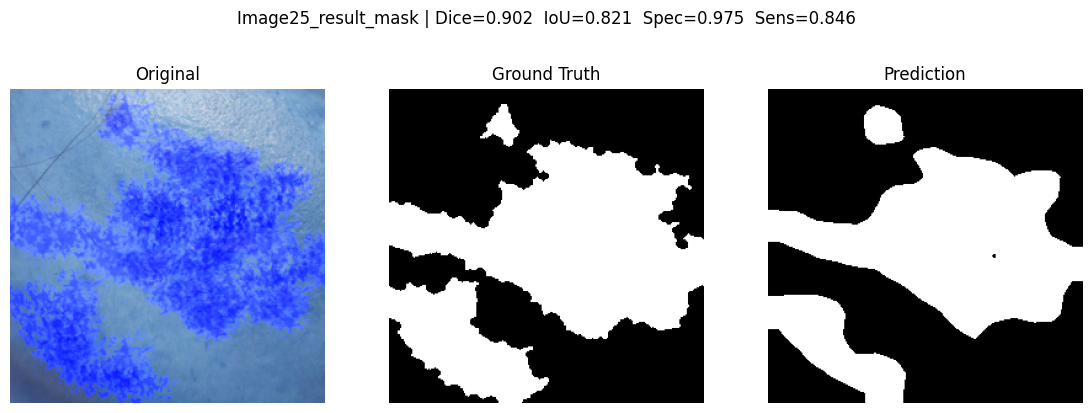

[RESULT] Image25_result_mask  Dice=0.9018  IoU=0.8212  Spec=0.9748  Sens=0.8459  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image25_result_mask_triptych.png


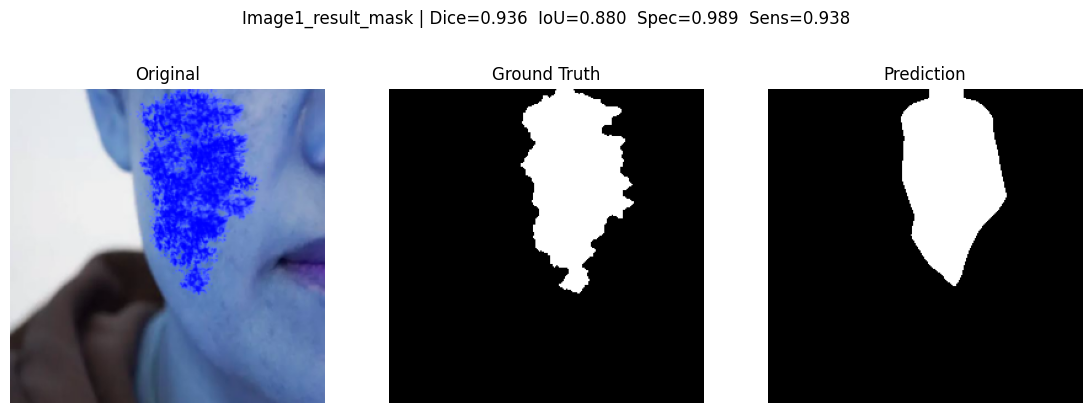

[RESULT] Image1_result_mask  Dice=0.9364  IoU=0.8803  Spec=0.9890  Sens=0.9380  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image1_result_mask_triptych.png


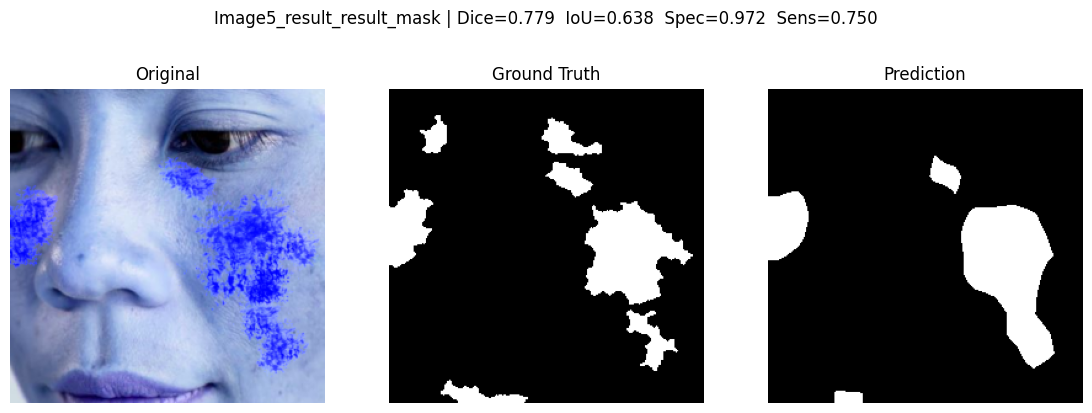

[RESULT] Image5_result_result_mask  Dice=0.7791  IoU=0.6382  Spec=0.9723  Sens=0.7504  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image5_result_result_mask_triptych.png


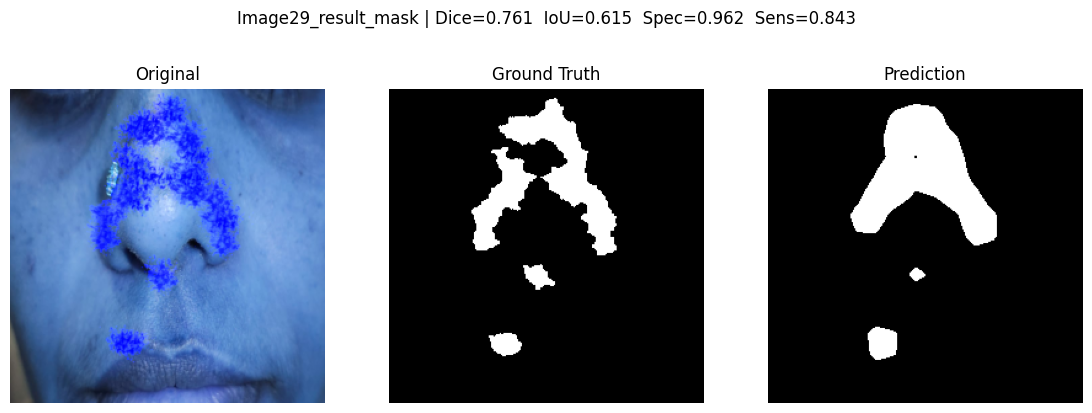

[RESULT] Image29_result_mask  Dice=0.7615  IoU=0.6148  Spec=0.9625  Sens=0.8427  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image29_result_mask_triptych.png


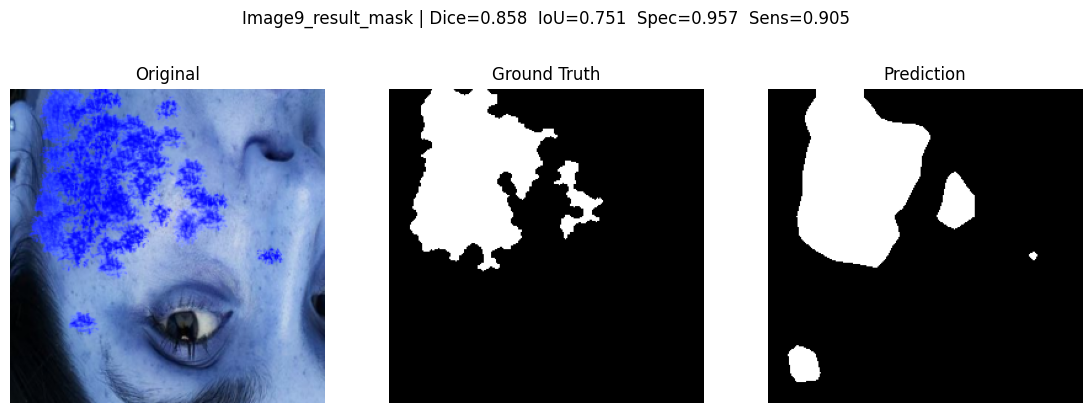

[RESULT] Image9_result_mask  Dice=0.8580  IoU=0.7513  Spec=0.9567  Sens=0.9053  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image9_result_mask_triptych.png


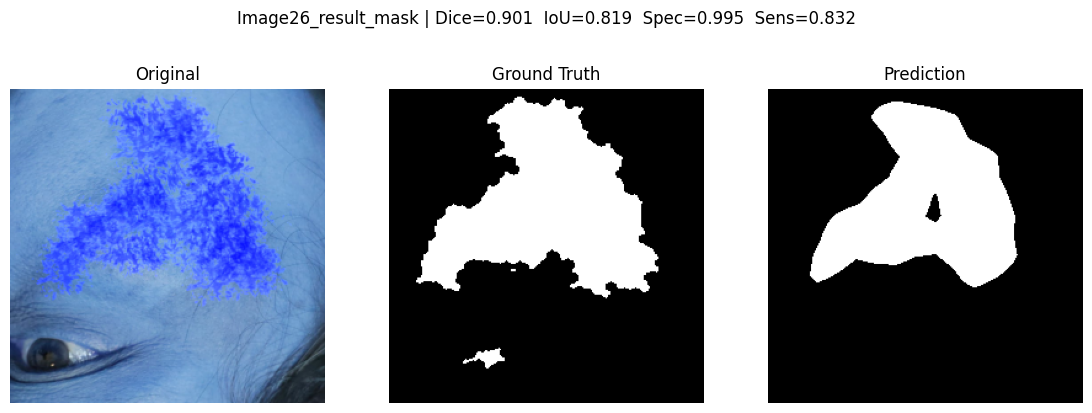

[RESULT] Image26_result_mask  Dice=0.9006  IoU=0.8191  Spec=0.9945  Sens=0.8316  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image26_result_mask_triptych.png


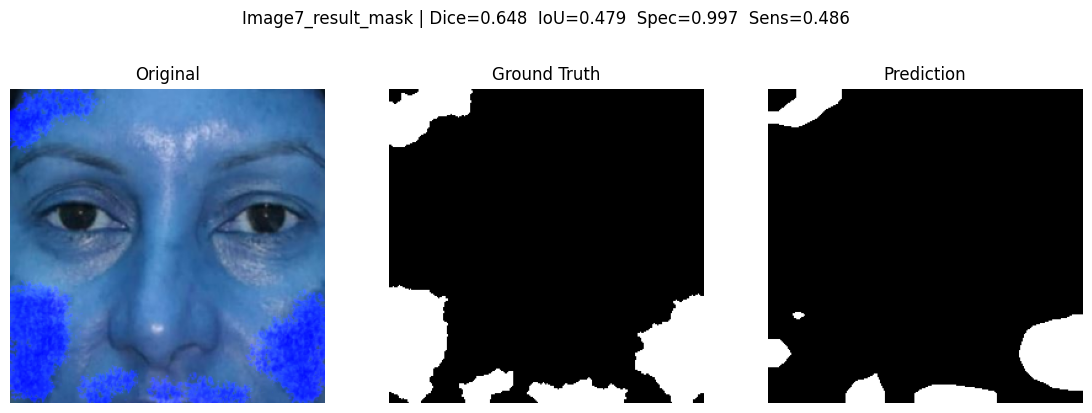

[RESULT] Image7_result_mask  Dice=0.6480  IoU=0.4793  Spec=0.9972  Sens=0.4858  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image7_result_mask_triptych.png


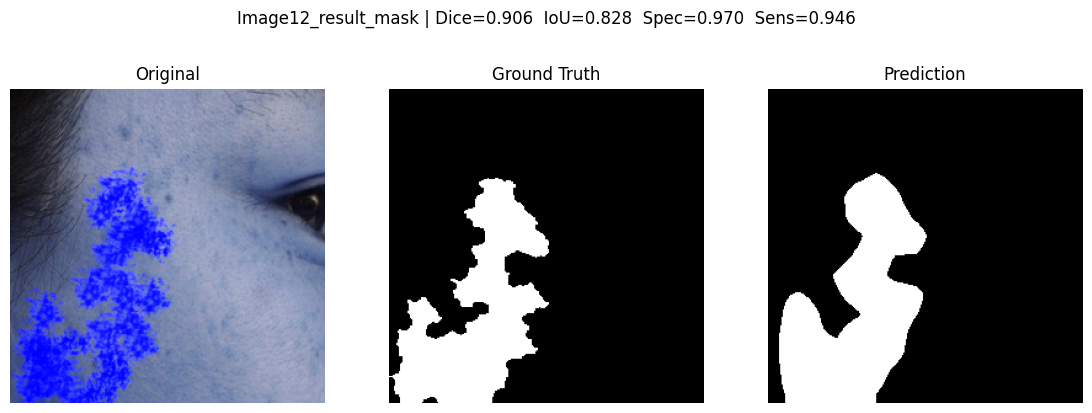

[RESULT] Image12_result_mask  Dice=0.9057  IoU=0.8276  Spec=0.9704  Sens=0.9457  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image12_result_mask_triptych.png


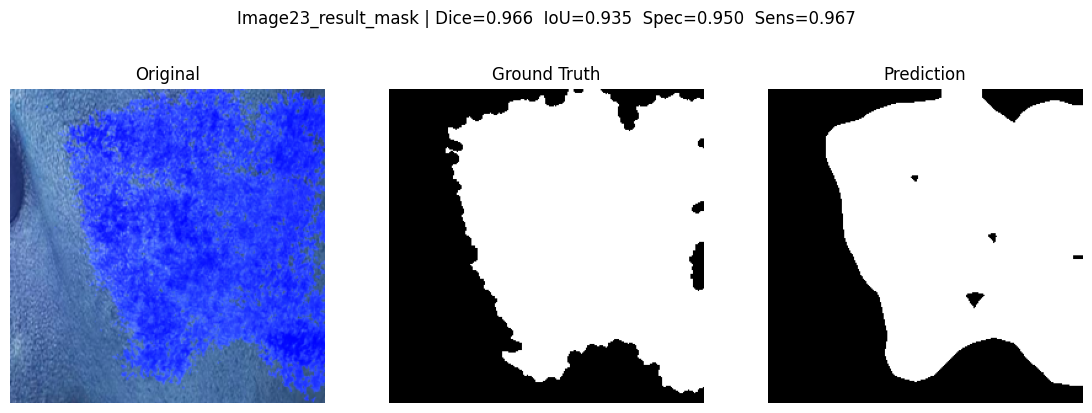

[RESULT] Image23_result_mask  Dice=0.9663  IoU=0.9349  Spec=0.9499  Sens=0.9667  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image23_result_mask_triptych.png


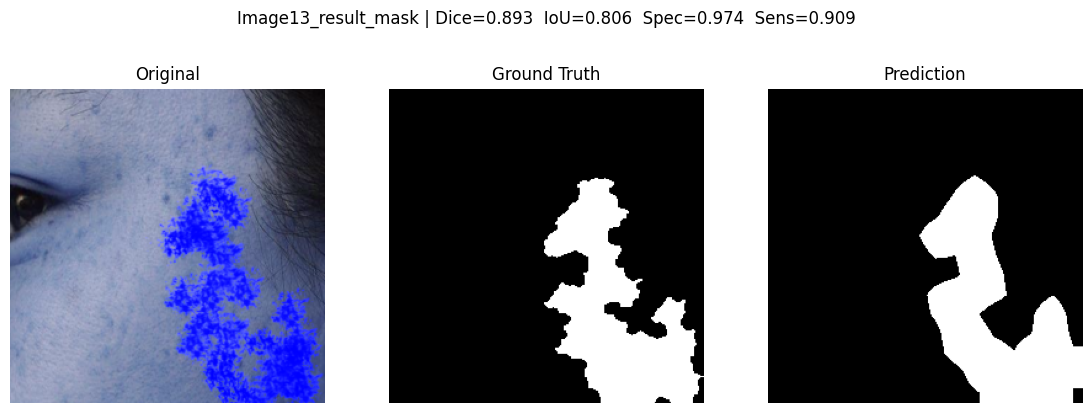

[RESULT] Image13_result_mask  Dice=0.8927  IoU=0.8062  Spec=0.9736  Sens=0.9087  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image13_result_mask_triptych.png


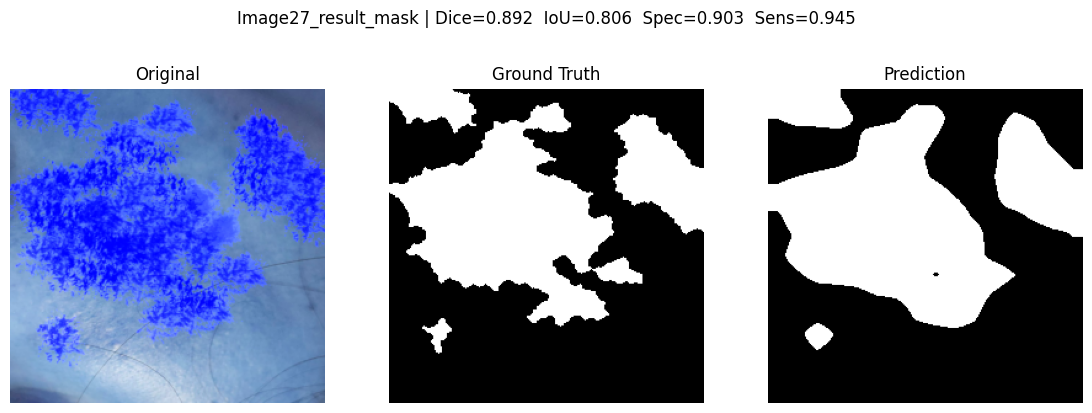

[RESULT] Image27_result_mask  Dice=0.8924  IoU=0.8056  Spec=0.9028  Sens=0.9446  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image27_result_mask_triptych.png


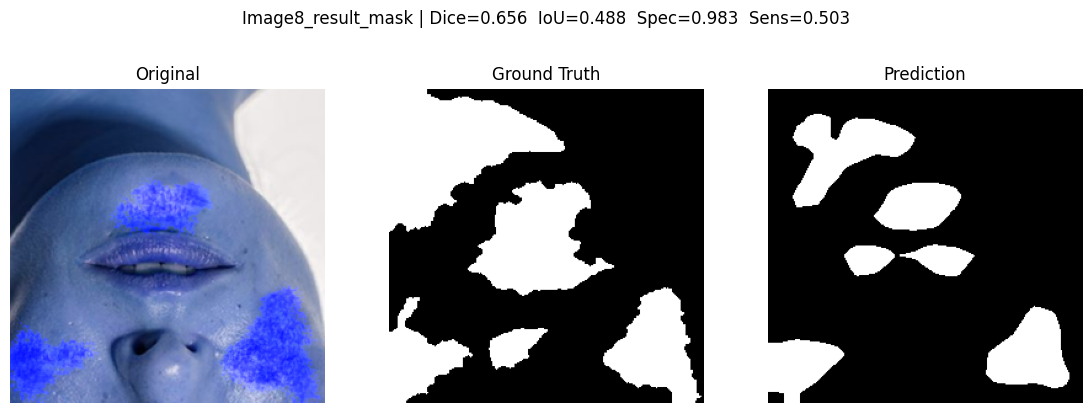

[RESULT] Image8_result_mask  Dice=0.6560  IoU=0.4881  Spec=0.9835  Sens=0.5027  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image8_result_mask_triptych.png


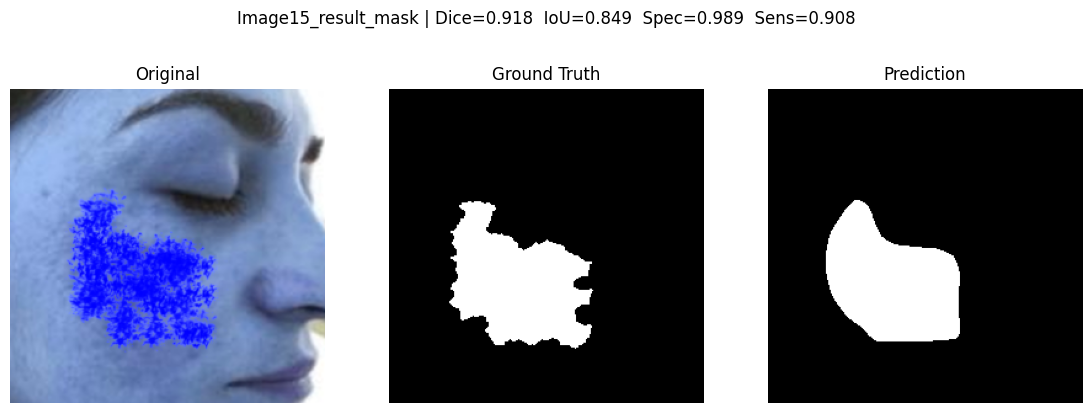

[RESULT] Image15_result_mask  Dice=0.9185  IoU=0.8492  Spec=0.9893  Sens=0.9083  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image15_result_mask_triptych.png


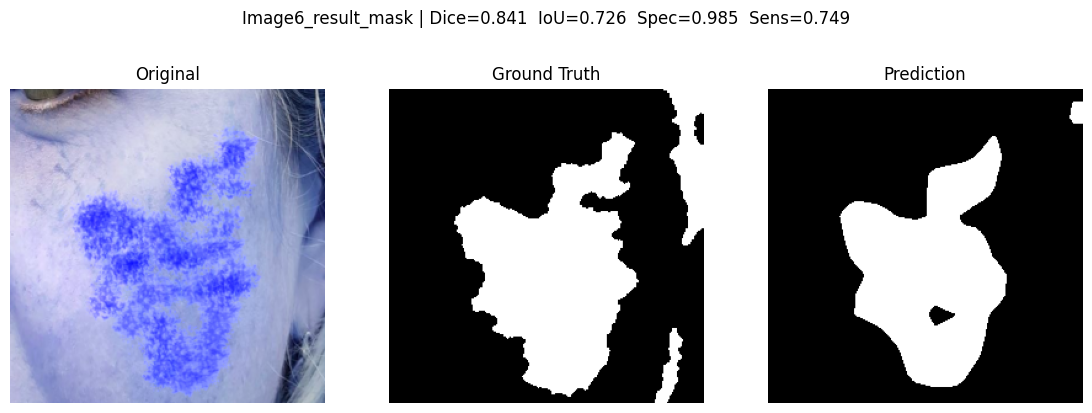

[RESULT] Image6_result_mask  Dice=0.8410  IoU=0.7256  Spec=0.9854  Sens=0.7493  | saved: /content/drive/MyDrive/dataset/models/train_all_triptychs/Image6_result_mask_triptych.png


In [ ]:
# Show ALL images, one figure per image (Original | GT | Pred)
# Saves (optional) and displays every single sample.

from torch.utils.data import DataLoader
import os
# ===========================
# Visualize per-sample results: Original | GT | Prediction
# With per-image metrics and optional saving
# ===========================
import os, numpy as np, matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def _single_metrics_from_bool(pred_bool, gt_bool, eps=1e-7):
    tp = (pred_bool & gt_bool).sum().item()
    fp = (pred_bool & (~gt_bool)).sum().item()
    fn = ((~pred_bool) & gt_bool).sum().item()
    tn = ((~pred_bool) & (~gt_bool)).sum().item()
    dice = (2*tp) / (2*tp + fp + fn + eps)
    iou  = tp / (tp + fp + fn + eps)
    spec = tn / (tn + fp + eps)            # specificity (TNR)
    sens = tp / (tp + fn + eps)            # sensitivity / recall (TPR)
    return dice, iou, spec, sens

@torch.no_grad()
def visualize_predictions(model,
                          loader,
                          device,
                          out_dir=None,
                          thr=0.50,
                          max_items=None,
                          show=True,
                          overlay=False,
                          overlay_alpha=0.35):
    """
    Displays (and optionally saves) a figure per image:
    [Original | Ground Truth | Predicted] + per-image metrics in the title.

    Args:
        model: segmentation model (logits output)
        loader: DataLoader yielding (imgs, masks, names)
        device: "cuda" or "cpu"
        out_dir: if provided, saves each panel as <out_dir>/<name>_triptych.png
        thr: threshold for binarizing predictions
        max_items: stop after this many samples (None = all)
        show: if True, plt.show() each figure
        overlay: if True, overlays GT and Pred on the original in semi-transparent color
        overlay_alpha: opacity for overlay masks
    Returns:
        List of (name, saved_path or None, metrics_dict)
    """
    model.eval()
    saved = []
    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)

    seen = 0
    for imgs, masks, names in loader:
        imgs  = imgs.to(device, non_blocking=(device=="cuda"))
        masks = masks.to(device, non_blocking=(device=="cuda"))
        logits = model(imgs)
        probs  = torch.sigmoid(logits)
        preds  = (probs > thr)

        B = imgs.size(0)
        for b in range(B):
            name = os.path.splitext(names[b])[0]

            # tensors -> numpy
            img_np = (imgs[b].detach().cpu().numpy().transpose(1,2,0) * 255.0).clip(0,255).astype(np.uint8)
            gt_np  = (masks[b,0].detach().cpu().numpy() > 0.5).astype(np.uint8)*255
            pr_np  = (preds[b,0].detach().cpu().numpy()).astype(np.uint8)*255

            # metrics (per image)
            dice, iou, spec, sens = _single_metrics_from_bool(pr_np.astype(bool), gt_np.astype(bool))
            metrics = {"dice": dice, "iou": iou, "specificity": spec, "sensitivity": sens}

            # figure
            fig = plt.figure(figsize=(12,4))

            # 1) Original
            ax1 = plt.subplot(1,3,1)
            ax1.imshow(img_np)
            ax1.set_title("Original")
            ax1.axis("off")

            # 2) Ground Truth
            ax2 = plt.subplot(1,3,2)
            if overlay:
                ax2.imshow(img_np)
                ax2.imshow(gt_np, cmap="Reds", alpha=overlay_alpha)
                ax2.set_title("Ground Truth (overlay)")
            else:
                ax2.imshow(gt_np, cmap="gray")
                ax2.set_title("Ground Truth")
            ax2.axis("off")

            # 3) Prediction
            ax3 = plt.subplot(1,3,3)
            if overlay:
                ax3.imshow(img_np)
                ax3.imshow(pr_np, cmap="Greens", alpha=overlay_alpha)
                ax3.set_title("Prediction (overlay)")
            else:
                ax3.imshow(pr_np, cmap="gray")
                ax3.set_title("Prediction")
            ax3.axis("off")

            # Big suptitle with metrics
            plt.suptitle(f"{name} | Dice={dice:.3f}  IoU={iou:.3f}  Spec={spec:.3f}  Sens={sens:.3f}",
                         y=1.02, fontsize=12)

            save_path = None
            if out_dir is not None:
                save_path = os.path.join(out_dir, f"{name}_triptych.png")
                plt.tight_layout()
                plt.savefig(save_path, dpi=150, bbox_inches="tight")
            if show:
                plt.tight_layout()
                plt.show()
            plt.close(fig)

            # Easy copy-paste line for your logs or reports
            print(f"[RESULT] {name}  Dice={dice:.4f}  IoU={iou:.4f}  Spec={spec:.4f}  Sens={sens:.4f}"
                  + (f"  | saved: {save_path}" if save_path else ""))

            saved.append((name, save_path, metrics))
            seen += 1
            if max_items is not None and seen >= max_items:
                return saved
    return saved

def visualize_all_images(model,
                         dataset,
                         device,
                         out_dir=None,
                         thr=0.50,
                         overlay=False,
                         overlay_alpha=0.35):
    """
    Ensures every sample is processed and shown by using batch_size=1, shuffle=False.
    Uses your existing `visualize_predictions` internally.
    """
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))
    return visualize_predictions(model,
                                 loader,
                                 device,
                                 out_dir=out_dir,
                                 thr=thr,
                                 max_items=None,     # <-- no cap; show ALL
                                 show=True,          # <-- display each figure
                                 overlay=overlay,
                                 overlay_alpha=overlay_alpha)
# Validation set (all images)
VAL_OUT = os.path.join(SAVE_DIR, "val_all_triptychs")
_ = visualize_all_images(model, val_ds, DEVICE, out_dir=VAL_OUT, thr=0.50, overlay=False)

# (Optional) Training set (all images)
TRAIN_OUT = os.path.join(SAVE_DIR, "train_all_triptychs")
_ = visualize_all_images(model, train_ds, DEVICE, out_dir=TRAIN_OUT, thr=0.50, overlay=False)


In [ ]:
import os
IMAGE_DIR = "/content/drive/MyDrive/dataset2/images2"
print(f"Listing files in: {IMAGE_DIR}")
if os.path.exists(IMAGE_DIR):
    print(os.listdir(IMAGE_DIR))
else:
    print(f"Directory not found: {IMAGE_DIR}")

Listing files in: /content/drive/MyDrive/dataset2/images2
Directory not found: /content/drive/MyDrive/dataset2/images2
